# Experiments 1:
### generating byte-to-integers representations derived from file first blocks to train and evaluate our models - FFNN, CNN, GRU, LSTM

In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.utils import get_file_types, get_1st_block_bytes, pad_array, convert_cat2num
from toolkit.models import Ffnn, Cnn, Lstm, Gru
from toolkit.metrics import evaluate_performance, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Preparation

In [2]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733699 entries, 0 to 733698
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   file    733699 non-null  object
 1   type    733699 non-null  object
dtypes: object(2)
memory usage: 11.2+ MB


In [4]:
df.describe()

,file,type
count,733699,733699
unique,733699,60
top,000000.swf,html
freq,1,185302


In [5]:
df['type'].unique()

array(['swf', 'doc', 'ppt', 'pdf', 'html', 'csv', 'xls', 'xml', 'txt',
       'unk', 'ps', 'jpg', 'wp', 'rtf', 'f', 'gif', 'dbase3', 'png', 'gz',
       'log', 'java', 'pps', 'text', 'tex', 'gls', 'eps', 'hlp', 'fits',
       'dwf', 'sql', 'kml', 'kmz', 'bmp', 'sgml', 'troff', 'docx', 'vrml',
       'ttf', 'pptx', 'xlsx', 'data', 'py', 'zip', 'wk1', 'g3', 'tmp',
       'pub', 'fm', 'odp', 'sys', 'js', '123', 'exported', 'pst', 'ileaf',
       'xbm', 'chp', 'lnk', 'wk3', ''], dtype=object)

In [6]:
# check for missing data
df.loc[df['type'].isna(), 'file'].value_counts()

Series([], Name: count, dtype: int64)

In [7]:
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [8]:
# filter the dataset to keep the targeted classes
df = df[df['type'].isin(CLASS_NAMES)]
df["type"].value_counts()

type
html    185302
pdf     176094
txt      72909
jpg      53522
doc      53274
xls      46835
ppt      39457
xml      26047
gif      14152
ps       12765
swf       3111
png       2482
Name: count, dtype: int64

In [9]:
# get file sizes in KB
df['size KB'] = df['file'].apply(
    lambda x: float(os.path.getsize(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) / 1024) if os.path.isfile(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) else None
)

print(f"The average file size is: {df['size KB'].mean()}")

The average file size is: 522.8481363551462


In [10]:
# sample 2000 files for each targeted file type
df = df.groupby('type').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)
df["type"].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_19616\350564064.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)


type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
png     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
Name: count, dtype: int64

In [11]:
df.sample(n=10)

,file,type,size KB
22634,482494.xml,xml,31.335938
19325,491204.txt,txt,37.017578
10398,017085.png,png,58.016602
11819,734397.png,png,7.497070
20626,724968.xls,xls,41.000000
5320,399203.html,html,11.962891
7415,132721.jpg,jpg,152.493164
12521,086258.ppt,ppt,1487.500000
10122,719727.png,png,103.920898
3596,716069.gif,gif,23.551758


In [12]:
# get the file first block bytes
base_dir = os.path.join(os.getcwd(), "govdocs1")
df["1st_block_bytes"] = df["file"].apply(lambda file: get_1st_block_bytes(os.path.join(base_dir, file)))

In [13]:
df.sample(n=10)

,file,type,size KB,1st_block_bytes
23550,565661.xml,xml,18.693359,"b'<?xml version=""1.0"" encoding=""ISO-8859-1""?>\..."
15065,481192.ps,ps,34780.132812,b'%!PS-Adobe-2.0\n%%Creator: dvipsk 5.55a Copy...
11473,189048.png,png,275.191406,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
11973,338816.png,png,3.418945,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
20980,508655.xls,xls,51.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...
9064,280713.pdf,pdf,66.274414,b'%PDF-1.4\r%\xe2\xe3\xcf\xd3\r\n273 0 obj <</...
13677,495546.ppt,ppt,1848.000000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...
6672,392777.jpg,jpg,875.758789,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...
7433,250854.jpg,jpg,17.752930,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...
2556,734975.gif,gif,2.908203,b'GIF87a\x10\x01\x18\x01\xf1\x00\x00\xff\xff\x...


In [14]:
# blocks on the disk of this computer contain 4096 bytes (4KB)
df["1st_block_bytes"].apply(len)

0        4096
1        4096
2        4096
3        4096
4        4096
         ... 
23995    4096
23996    4096
23997    4096
23998    4096
23999    4096
Name: 1st_block_bytes, Length: 24000, dtype: int64

In [15]:
# convert bytes to byte-to-integers
df["byte_integers"] = df["1st_block_bytes"].apply(lambda byte_sequence: np.array([byte for byte in byte_sequence]))
df.sample(n=5)

,file,type,size KB,1st_block_bytes,byte_integers
9646,480196.pdf,pdf,295.299805,b'%PDF-1.5\r%\xe2\xe3\xcf\xd3\r\n2823 0 obj<</...,"[37, 80, 68, 70, 45, 49, 46, 53, 13, 37, 226, ..."
846,149768.doc,doc,474.000000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[208, 207, 17, 224, 161, 177, 26, 225, 0, 0, 0..."
3159,552056.gif,gif,137.440430,b'GIF87a\xd0\x02X\x02\xf7\x00\x00\x00\x00\x00\...,"[71, 73, 70, 56, 55, 97, 208, 2, 88, 2, 247, 0..."
15963,195497.ps,ps,4055.626953,b'%!PS-Adobe-2.0\n%%Creator: dvips(k) 5.86 Cop...,"[37, 33, 80, 83, 45, 65, 100, 111, 98, 101, 45..."
8126,145145.pdf,pdf,2657.946289,b'%PDF-1.2\r%\xe2\xe3\xcf\xd3\r\n1 0 obj\r<<\r...,"[37, 80, 68, 70, 45, 49, 46, 50, 13, 37, 226, ..."


In [16]:
# pad arrays since for this experiment files can be smaller than 4kb
# this means that null byte values could be in these files
df["byte_integers"] = df["byte_integers"].apply(lambda arr: pad_array(arr, length=4096))

In [17]:
# check that our arrays are homogeneous
byte_lengths = df["byte_integers"].apply(len)
all_same_length = byte_lengths.nunique() == 1

print("byte lengths of each sequence:\n", byte_lengths)
print("all byte sequences of the same length:", all_same_length)

byte lengths of each sequence:
 0        4096
1        4096
2        4096
3        4096
4        4096
         ... 
23995    4096
23996    4096
23997    4096
23998    4096
23999    4096
Name: byte_integers, Length: 24000, dtype: int64
all byte sequences of the same length: True


In [18]:
df["type"].value_counts()

type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
png     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
Name: count, dtype: int64

In [19]:
# convert categorical classes to numerical
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))
df.sample(n=10)

,file,type,size KB,1st_block_bytes,byte_integers,class
3687,399745.gif,gif,9.458984,b'GIF89al\x00l\x00\xe6\x00\x00\x92uukLL\xff\xf...,"[71, 73, 70, 56, 57, 97, 108, 0, 108, 0, 230, ...",7
710,547411.doc,doc,440.000000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[208, 207, 17, 224, 161, 177, 26, 225, 0, 0, 0...",1
7490,124391.jpg,jpg,580.023438,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",8
7718,685569.jpg,jpg,11.165039,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",8
20300,601280.xls,xls,282.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[208, 207, 17, 224, 161, 177, 26, 225, 0, 0, 0...",4
21820,622215.xls,xls,39.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[208, 207, 17, 224, 161, 177, 26, 225, 0, 0, 0...",4
18445,101302.txt,txt,268.545898,"b""<DOC>\n[October 31,2005 (Volume 70, Number ...","[60, 68, 79, 67, 62, 10, 91, 79, 99, 116, 111,...",11
14400,030792.ps,ps,760.114258,b'%!PS-Adobe-3.0\n%%Title: letters.p65\n%%Crea...,"[37, 33, 80, 83, 45, 65, 100, 111, 98, 101, 45...",3
2988,059107.gif,gif,49.410156,b'GIF87a \x03\x84\x03\xf4\x00\x00\xff\xff\xff\...,"[71, 73, 70, 56, 55, 97, 32, 3, 132, 3, 244, 0...",7
13908,318471.ppt,ppt,3282.000000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"[208, 207, 17, 224, 161, 177, 26, 225, 0, 0, 0...",5


In [20]:
df["class"].value_counts()

class
1     2000
7     2000
10    2000
8     2000
2     2000
9     2000
5     2000
3     2000
6     2000
11    2000
4     2000
12    2000
Name: count, dtype: int64

In [21]:
# create feature and label arrays
X = np.array([x for x in df["byte_integers"]])
y = np.array([y for y in df["class"]])

# printing our array shapes
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (24000, 4096)
y shape:  (24000,)


In [22]:
# split the data to training, validation, and testing arrays
# 70% training and 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:
print("X training shape: ", X_train.shape)
print("X validation shape: ", X_val.shape)
print("X testing shape: ", X_test.shape, "\n")
print("y training shape: ", y_train.shape)
print("y validation shape: ", y_val.shape)
print("y testing shape: ", y_test.shape)

X training shape:  (16800, 4096)
X validation shape:  (3600, 4096)
X testing shape:  (3600, 4096) 

y training shape:  (16800,)
y validation shape:  (3600,)
y testing shape:  (3600,)


## 2. Models Training and Evaluation

### Feed Forward Neural Network

In [27]:
ffnn = Ffnn(timesteps=4096, features=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096, 256)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │     6,815,757 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,849,165 (26.13 MB)

 Trainable params: 6,849,165 (26.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
ffnn_pred = ffnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 179s 338ms/step - accuracy: 0.4917 - loss: 111.3023 - val_accuracy: 0.7172 - val_loss: 1.0686
Epoch 2/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 168s 321ms/step - accuracy: 0.7315 - loss: 0.9249 - val_accuracy: 0.7278 - val_loss: 0.8963
Epoch 3/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 173s 330ms/step - accuracy: 0.7339 - loss: 0.7683 - val_accuracy: 0.7222 - val_loss: 0.8497
Epoch 4/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 174s 331ms/step - accuracy: 0.7388 - loss: 0.6783 - val_accuracy: 0.7275 - val_loss: 0.7974


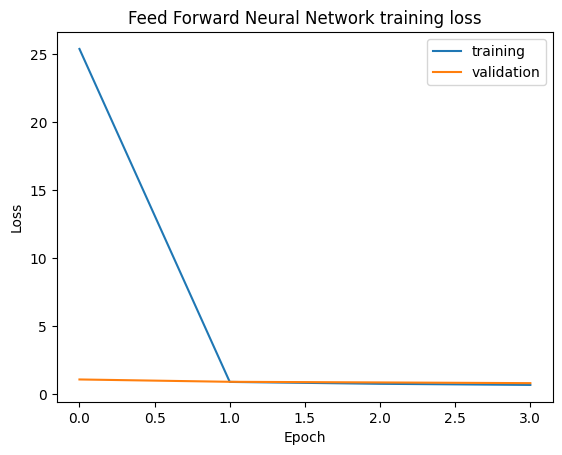

In [29]:
ffnn.plot_learning_curves()

In [30]:
ffnn_pred = ffnn.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step


In [31]:
metrics = evaluate_performance(y_test, ffnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.7383333333333333.
precision	0.6755883705089333.
recall		0.732518720346325.
f1-score	0.6850092528815388.


c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
ffnn_report = classification_report(y_test, ffnn_pred, target_names=CLASS_NAMES)
print(ffnn_report)

              precision    recall  f1-score   support

         doc       0.99      1.00      0.99       287
         pdf       0.98      0.90      0.94       317
          ps       0.24      0.98      0.38       287
         xls       0.99      0.99      0.99       304
         ppt       0.99      1.00      0.99       307
         swf       0.96      0.97      0.97       307
         gif       0.98      0.98      0.98       308
         jpg       0.97      0.99      0.98       295
         png       1.00      0.98      0.99       311
        html       0.00      0.00      0.00       303
         txt       0.00      0.00      0.00       285
         xml       0.00      0.00      0.00       289

    accuracy                           0.74      3600
   macro avg       0.68      0.73      0.69      3600
weighted avg       0.68      0.74      0.69      3600



c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

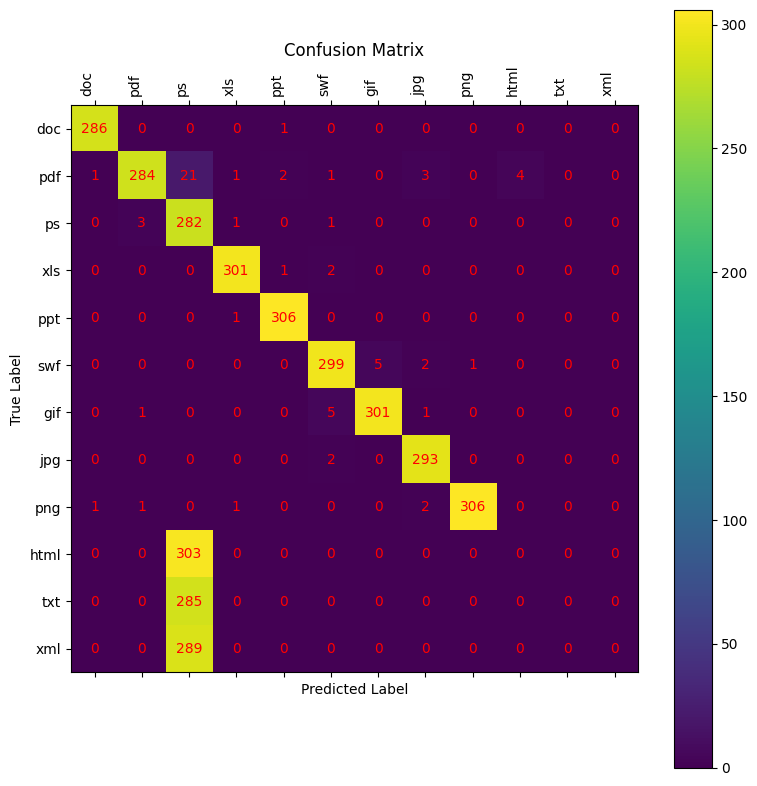

In [33]:
ffnn_cm = confusion_matrix(y_test, ffnn_pred)
plot_confusion_matrix(ffnn_cm, CLASS_NAMES)

### Convolutional Neural Network

In [34]:
cnn = Cnn(timesteps=4096, features=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4094, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2047, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2045, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1022, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 130816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │     1,700,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,725,581 (6.58 MB)

 Trainable params: 1,725,581 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
cnn_history = cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 87s 163ms/step - accuracy: 0.6836 - loss: 62.9964 - val_accuracy: 0.8925 - val_loss: 0.4073
Epoch 2/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 88s 168ms/step - accuracy: 0.9345 - loss: 0.2164 - val_accuracy: 0.9067 - val_loss: 0.5079
Epoch 3/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 88s 167ms/step - accuracy: 0.9711 - loss: 0.1027 - val_accuracy: 0.9103 - val_loss: 0.6115
Epoch 4/4
525/525 ━━━━━━━━━━━━━━━━━━━━ 90s 172ms/step - accuracy: 0.9796 - loss: 0.0710 - val_accuracy: 0.9106 - val_loss: 0.6069


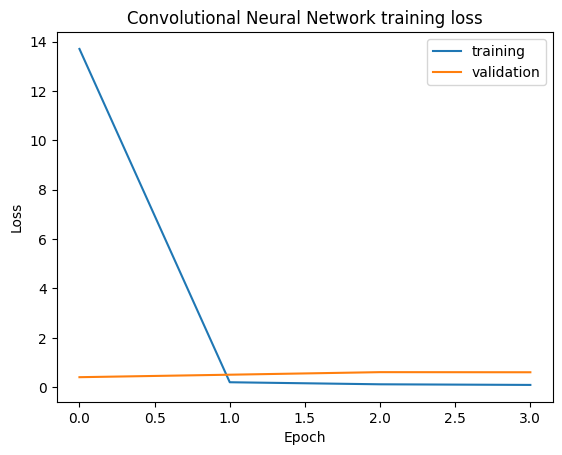

In [36]:
cnn.plot_learning_curves()

In [37]:
cnn_pred = cnn.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step


In [38]:
metrics = evaluate_performance(y_test, cnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.9130555555555555.
precision	0.9123263124660443.
recall		0.9113487252842093.
f1-score	0.9111757876435879.


In [39]:
cnn_report = classification_report(y_test, cnn_pred, target_names=CLASS_NAMES)
print(cnn_report)

              precision    recall  f1-score   support

         doc       0.99      1.00      0.99       287
         pdf       1.00      0.97      0.98       317
          ps       0.89      0.94      0.92       287
         xls       0.98      0.97      0.97       304
         ppt       0.98      0.97      0.97       307
         swf       0.94      0.95      0.94       307
         gif       0.96      0.96      0.96       308
         jpg       0.99      0.98      0.99       295
         png       0.99      0.98      0.99       311
        html       0.67      0.77      0.72       303
         txt       0.67      0.58      0.62       285
         xml       0.89      0.86      0.87       289

    accuracy                           0.91      3600
   macro avg       0.91      0.91      0.91      3600
weighted avg       0.91      0.91      0.91      3600



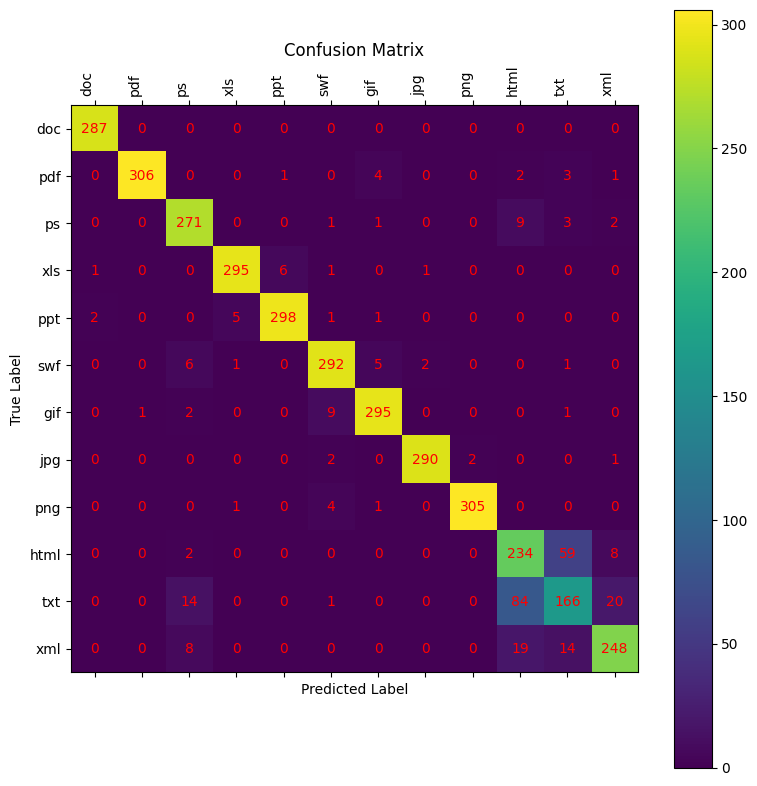

In [40]:
cnn_cm = confusion_matrix(y_test, cnn_pred)
plot_confusion_matrix(cnn_cm, CLASS_NAMES)

### Gated Reccurent Unit

In [41]:
gru = Gru(timesteps=4096, features=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 136)            │        28,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,749 (120.11 KB)

 Trainable params: 30,749 (120.11 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1421s 3s/step - accuracy: 0.5985 - loss: 1.3513 - val_accuracy: 0.9219 - val_loss: 0.2952
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1517s 3s/step - accuracy: 0.9279 - loss: 0.2505 - val_accuracy: 0.9517 - val_loss: 0.1627
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1591s 3s/step - accuracy: 0.9493 - loss: 0.1654 - val_accuracy: 0.9494 - val_loss: 0.1937
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1925s 4s/step - accuracy: 0.9473 - loss: 0.1885 - val_accuracy: 0.9322 - val_loss: 0.2327
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 2452s 5s/step - accuracy: 0.9198 - loss: 0.3114 - val_accuracy: 0.9394 - val_loss: 0.2622
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1750s 3s/step - accuracy: 0.9467 - loss: 0.2265 - val_accuracy: 0.9586 - val_loss: 0.1702
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1704s 3s/step - accuracy: 0.9576 - loss: 0.1673 - val_accuracy: 0.9625 - val_loss: 0.1371
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1706s 3s/step - accuracy: 0.9620 - loss: 0.1369 - 

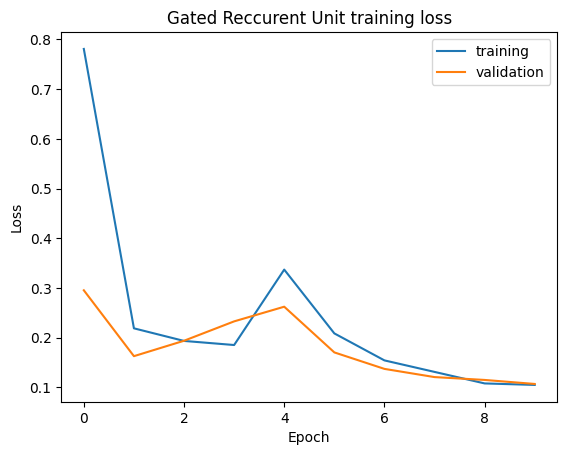

In [43]:
gru.plot_learning_curves()

In [44]:
gru_pred = gru.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 95s 833ms/step


In [45]:
metrics = evaluate_performance(y_test, gru_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{gru.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Gated Reccurent Unit performance evaluation:

accuracy	0.9669444444444445.
precision	0.9668822061533948.
recall		0.9666802966189384.
f1-score	0.9662653175839507.


In [46]:
gru_report = classification_report(y_test, gru_pred, target_names=CLASS_NAMES)
print(gru_report)

              precision    recall  f1-score   support

         doc       0.97      1.00      0.98       287
         pdf       0.98      0.99      0.99       317
          ps       0.98      0.98      0.98       287
         xls       0.98      0.98      0.98       304
         ppt       0.99      0.97      0.98       307
         swf       0.99      1.00      1.00       307
         gif       1.00      0.99      1.00       308
         jpg       1.00      1.00      1.00       295
         png       1.00      1.00      1.00       311
        html       0.92      0.81      0.86       303
         txt       0.94      0.93      0.93       285
         xml       0.84      0.94      0.89       289

    accuracy                           0.97      3600
   macro avg       0.97      0.97      0.97      3600
weighted avg       0.97      0.97      0.97      3600



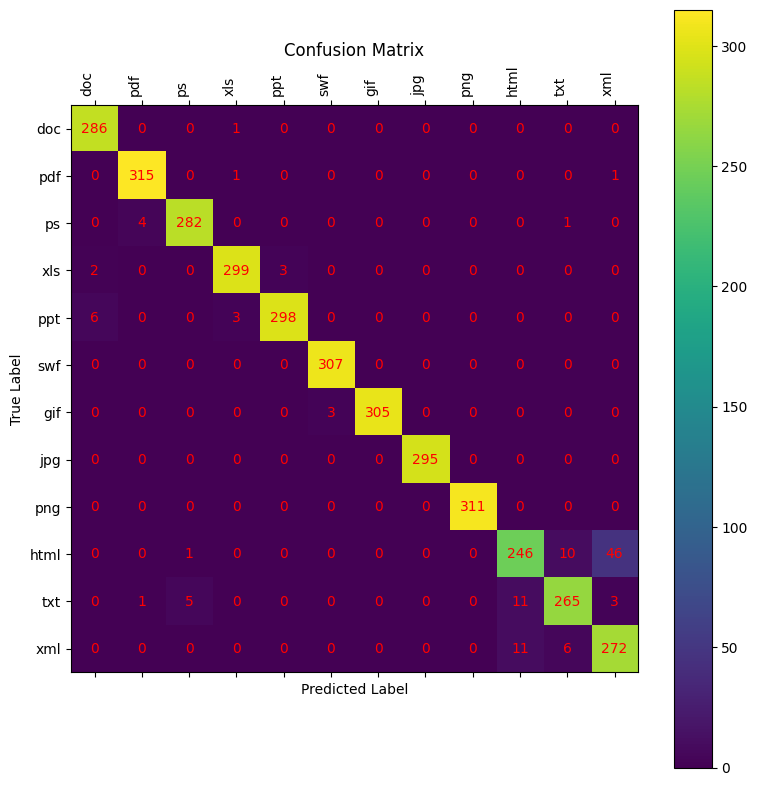

In [47]:
gru_cm = confusion_matrix(y_test, gru_pred)
plot_confusion_matrix(gru_cm, CLASS_NAMES)

### Long Short-Term Memory

In [48]:
lstm = Lstm(timesteps=4096, features=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 136)            │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,861 (155.71 KB)

 Trainable params: 39,861 (155.71 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
lstm_history = lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1554s 3s/step - accuracy: 0.5933 - loss: 1.3817 - val_accuracy: 0.8997 - val_loss: 0.3626
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1584s 3s/step - accuracy: 0.9072 - loss: 0.3224 - val_accuracy: 0.9156 - val_loss: 0.2473
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1615s 3s/step - accuracy: 0.9370 - loss: 0.2021 - val_accuracy: 0.9489 - val_loss: 0.1693
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1666s 3s/step - accuracy: 0.9559 - loss: 0.1422 - val_accuracy: 0.9500 - val_loss: 0.1414
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1641s 3s/step - accuracy: 0.9641 - loss: 0.1192 - val_accuracy: 0.9636 - val_loss: 0.1201
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1646s 3s/step - accuracy: 0.9701 - loss: 0.0973 - val_accuracy: 0.9383 - val_loss: 0.1744
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1677s 3s/step - accuracy: 0.9707 - loss: 0.0955 - val_accuracy: 0.9619 - val_loss: 0.1183
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 1645s 3s/step - accuracy: 0.9704 - loss: 0.0983 - 

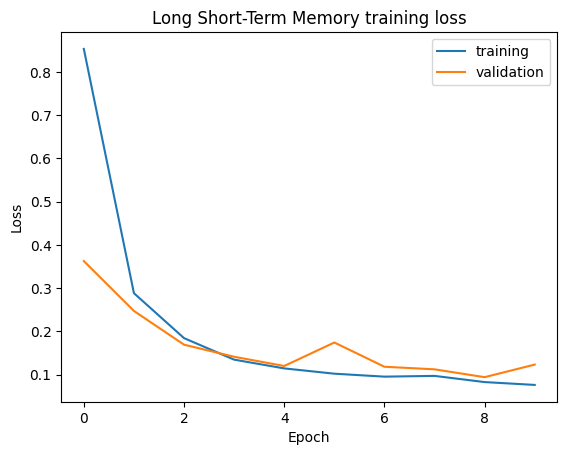

In [50]:
lstm.plot_learning_curves()

In [52]:
lstm_pred = lstm.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 579ms/step


In [53]:
metrics = evaluate_performance(y_test, lstm_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{lstm.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Long Short-Term Memory performance evaluation:

accuracy	0.9711111111111111.
precision	0.9708866509969534.
recall		0.9708939257217853.
f1-score	0.9707987377283892.


In [54]:
lstm_report = classification_report(y_test, lstm_pred, target_names=CLASS_NAMES)
print(lstm_report)

              precision    recall  f1-score   support

         doc       0.94      0.96      0.95       287
         pdf       0.99      1.00      1.00       317
          ps       0.98      1.00      0.99       287
         xls       0.93      0.95      0.94       304
         ppt       0.94      0.90      0.92       307
         swf       1.00      1.00      1.00       307
         gif       1.00      1.00      1.00       308
         jpg       1.00      1.00      1.00       295
         png       1.00      1.00      1.00       311
        html       0.94      0.94      0.94       303
         txt       0.97      0.94      0.96       285
         xml       0.96      0.97      0.96       289

    accuracy                           0.97      3600
   macro avg       0.97      0.97      0.97      3600
weighted avg       0.97      0.97      0.97      3600



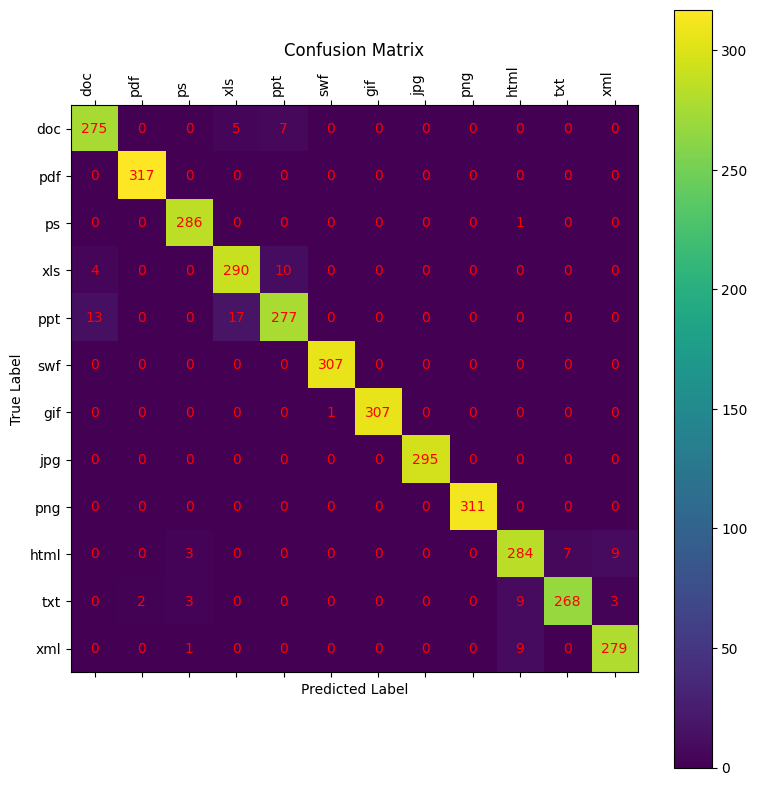

In [55]:
lstm_cm = confusion_matrix(y_test, lstm_pred)
plot_confusion_matrix(lstm_cm, CLASS_NAMES)